# Simple Linear Regression on DBNN

In [1]:
import math
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dbnn.dbnn import DBNN
from dbnn.och import OCH

In [2]:
savefig = False

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

if not savefig:
    plt.rcParams["figure.figsize"] = (4, 4)
    plt.rcParams["font.size"] = 15
    plt.rcParams["figure.titlesize"] = 25
    plt.rcParams["axes.labelsize"] = 20
    plt.rcParams["xtick.labelsize"] = 15
    plt.rcParams["ytick.labelsize"] = 15
    plt.rcParams["legend.fontsize"] = 13
    plt.rcParams["lines.linewidth"] = 2
else:
    plt.rcParams["figure.figsize"] = (8, 8)
    plt.rcParams["font.size"] = 30
    plt.rcParams["axes.labelsize"] = 53
    plt.rcParams["xtick.labelsize"] = 40
    plt.rcParams["ytick.labelsize"] = 40
    plt.rcParams["legend.fontsize"] = 28
    plt.rcParams["lines.linewidth"] = 4

In [3]:
# experiment
v, x_0_var = 0.2, 0.0
start, end = 0.0, 3.0
iter_no = 100
seed = 100

# model
op = lambda x: [x[0], x[1][0] * x[0] + x[1][1]]
x_1_means, x_1_vars = tf.constant([1.0, 0.0]), tf.constant([0.0, 0.2])

# och parameters
x_dims, y_dims = [1, 2], [1, 1]
och_x1_params = {'k': 5, 'l': 5.0, 's': 1.0}
och_x_params = {'k': 5, 'l': 1.0, 's': 1.0}
och_y_params = {'k': 5, 'l': 1.0, 's': 1.0}

# style
alpha = 0.12
colors = ["tab:blue", "tab:green", "tab:purple", "tab:red"]
labels = ["DNN", "MU", "DU", "DBNN"]
guide_linestyle=(0, (1, 1))
linestyles = [(0, (5, 1)), 'solid', (0, (5, 1)), 'solid']

In [4]:
tf.random.set_seed(seed)
np.random.seed(seed)

step = math.floor((end - start) / v) + 1
x_0_meanss = [v * tf.reshape(tf.range(step, dtype=tf.float32), shape=[step, 1]) + start * tf.ones(shape=[step, 1]) for _ in range(iter_no)]
x_0_ess = [x_0_var * tf.random.normal(shape=[step, 1]) for _ in range(iter_no)]
x_0ss = [x_0_means + x_0_es for x_0_means, x_0_es in zip(x_0_meanss, x_0_ess)]
x_0lat = x_0ss[0][-1].numpy()

## DNN

In [5]:
dnn_xs, dnn_ys, dnn_y_exps, dnn_y_vars = [], [], [], []
for x_0s in x_0ss:
    dnn_y_exp, dnn_y_var, dnn_runtimes = [], [], []
    for x_0 in x_0s:
        x_1s = [x_1_means]
        dnn_xs = [[x_0, x_1] for x_1 in x_1s]
        time1 = time.time()
        dnn_ys = [op(x) for x in dnn_xs]
        time2 = time.time()
        
        mean, variance = tf.nn.moments(tf.stack([dnn_y for dnn_y in dnn_ys]), axes=[0])
        dnn_y_exp.append(mean)
        dnn_y_var.append(variance)
        dnn_runtimes.append(time2 - time1)
    dnn_y_exps.append(dnn_y_exp)
    dnn_y_vars.append(dnn_y_var)

print("DNN Runtime: %.3f ± %.3f (ms)" % ( np.mean(dnn_runtimes) * 10 ** 3, np.std(dnn_runtimes) * 10 ** 3))

DNN Runtime: 0.184 ± 0.002 (ms)


## Model Uncertainty (MU)

In [6]:
x_1_sample_no = 30

mu_xs, mu_ys, mu_y_exps, mu_y_vars, mu_runtimes = [], [], [], [], []
for x_0s in x_0ss:
    mu_y_exp, mu_y_var = [], []
    for x_0 in x_0s:
        x_1s = [tf.random.normal(shape=[len(x_1_vars)]) * x_1_vars + x_1_means for _ in range(x_1_sample_no)]
        mu_xs = [[x_0, x_1] for x_1 in x_1s]
        time1 = time.time()
        mu_ys = [op(x) for x in mu_xs]
        time2 = time.time()
        
        mean, variance = tf.nn.moments(tf.stack([mu_y for mu_y in mu_ys]), axes=[0])
        mu_y_exp.append(mean)
        mu_y_var.append(variance)
        mu_runtimes.append(time2 - time1)
    mu_y_exps.append(mu_y_exp)
    mu_y_vars.append(mu_y_var)

print("MU Runtime: %.3f ± %.3f (ms)" % ( np.mean(mu_runtimes) * 10 ** 3, np.std(mu_runtimes) * 10 ** 3))

MU Runtime: 5.511 ± 0.493 (ms)


## Data Uncertainty (DU)

In [7]:
x_1s = [[x_1_means]]
och_x_1 = OCH(**och_x1_params, dims=x_dims[1:], hash_no=3, cs=x_1s)
och_x = OCH(**och_x_params, dims=x_dims, hash_no=1)
och_y = OCH(**och_y_params, dims=y_dims, hash_no=1)
du = DBNN(op, och_x_1, och_x, och_y)

du_y_exps, du_y_vars, du_runtimes = [], [], []
for x_0s in x_0ss:
    du.clear()
    du_y_exp, du_y_var = [], []
    for x_0 in x_0s:
        time1 = time.time()
        du.update(x_0)
        time2 = time.time()
        
        du_y_exp.append(du.och_y.expected())
        du_y_var.append(du.och_y.var())
        du_runtimes.append(time2 - time1)
    du_y_exps.append(du_y_exp)
    du_y_vars.append(du_y_var)
        
du_xs = [c for c, _ in du.och_x.cws()]
du_xws = [w for _, w in du.och_x.cws()]
du_ys = [c for c, _ in du.och_y.cws()] 
du_yws = [w for _, w in du.och_y.cws()]

print("DU Runtime: %.3f ± %.3f (ms)" % ( np.mean(du_runtimes) * 10 ** 3, np.std(du_runtimes) * 10 ** 3))

DU Runtime: 4.435 ± 2.106 (ms)


## DBNN

In [8]:
x_1s = [[x_1_means + tf.random.normal(shape=[len(x_1_vars)]) * x_1_vars] for _ in range(och_x1_params['k'])]
och_x_1 = OCH(**och_x1_params, dims=x_dims[1:], hash_no=3, cs=x_1s)
och_x = OCH(**och_x_params, dims=x_dims, hash_no=1)
och_y = OCH(**och_y_params, dims=y_dims, hash_no=1)
dbnn = DBNN(op, och_x_1, och_x, och_y)

dbnn_y_exps, dbnn_y_vars, dbnn_runtimes = [], [], []
for x_0s in x_0ss:
    dbnn.clear()
    dbnn_y_exp, dbnn_y_var = [], []
    for x_0 in x_0s:
        time1 = time.time()
        dbnn.update(x_0)
        time2 = time.time()
        
        dbnn_y_exp.append(dbnn.och_y.expected())
        dbnn_y_var.append(dbnn.och_y.var())
        dbnn_runtimes.append(time2 - time1)
    dbnn_y_exps.append(dbnn_y_exp)
    dbnn_y_vars.append(dbnn_y_var)

dbnn_xs = [c for c, _ in dbnn.och_x.cws()] 
dbnn_xws = [w for _, w in dbnn.och_x.cws()] 
dbnn_ys = [c for c, _ in dbnn.och_y.cws()] 
dbnn_yws = [w for _, w in dbnn.och_y.cws()] 

print("DBNN Runtime: %.3f ± %.3f (ms)" % ( np.mean(dbnn_runtimes) * 10 ** 3, np.std(dbnn_runtimes) * 10 ** 3))

DBNN Runtime: 4.956 ± 2.679 (ms)


## x-y Plot

/Users/namukpark/Dropbox/code-repository/personals/dbnn/venv/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Attempting to set identical bottom == top == 1.0 results in singular transformations; automatically expanding.


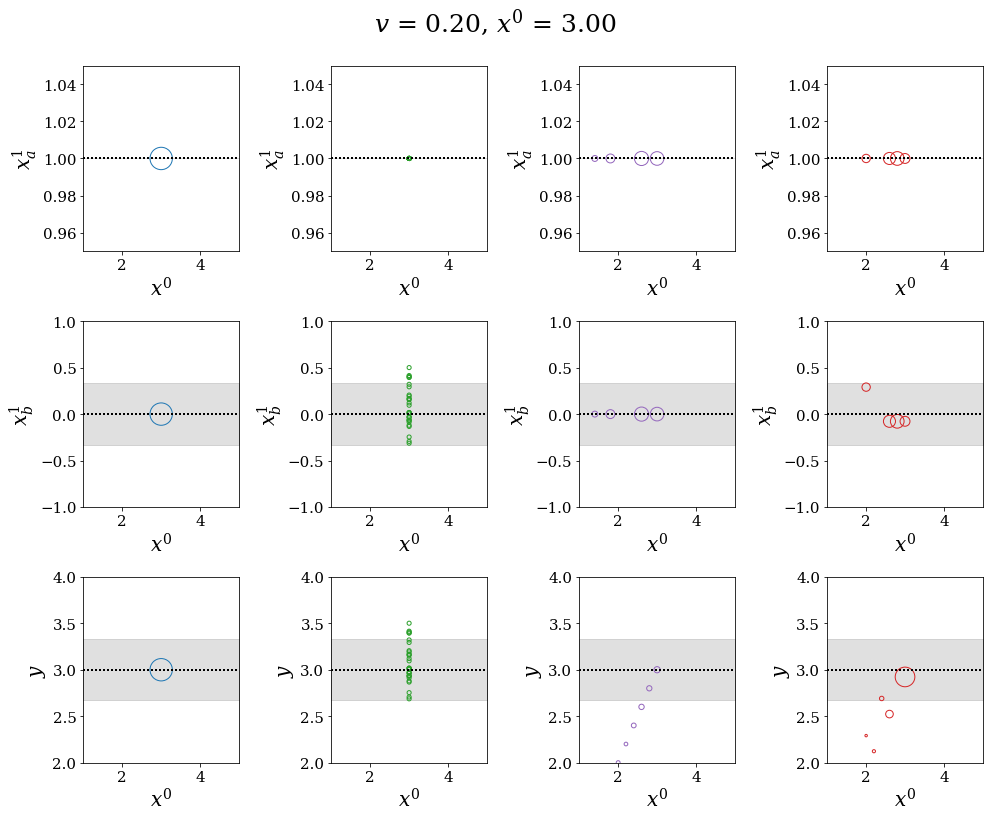

In [9]:
xs = [dnn_xs, mu_xs, du_xs, dbnn_xs]
xws = [np.ones(len(dnn_xs)) / (len(dnn_xs)), np.ones(len(mu_xs)) / (len(mu_xs)), du_xws, dbnn_xws]
ys = [dnn_ys, mu_ys, du_ys, dbnn_ys]
yws = [np.ones(len(dnn_ys)) / (len(dnn_ys)), np.ones(len(mu_ys)) / (len(mu_ys)), du_yws, dbnn_yws]

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(14, 12))
fig.suptitle("$v$ = %0.2f" % v + ", $x^0$ = %0.2f" % x_0lat)

for i, (x, xw, y, yw, color) in enumerate(zip(xs, xws, ys, yws, colors)):    
    x_0s = [x_0.numpy() for x_0, _ in x]
    x_0_start, x_0_end = x_0lat[0] - 2, x_0lat[0] + 2
    
    x_1as, x_1bs = [x_1[0].numpy() for _, x_1 in x], [x_1[1].numpy() for _, x_1 in x]
    x_1_start, x_1_end = (x_1_means - x_1_vars * 1.65).numpy(), (x_1_means + x_1_vars * 1.65).numpy()
    x_1_start_lim, x_1_end_lim = (x_1_means - x_1_vars * 5).numpy(), (x_1_means + x_1_vars * 5).numpy()

    y_0s, y_1s = [y_0.numpy() for y_0, _ in y], [y_1.numpy() for _, y_1 in y]
    x_mean, x_start, x_end = [x_0lat, x_1_means], [x_0lat, x_1_start], [x_0lat, x_1_end]
    y_mean, y_start, y_end = op(x_mean), op(x_start), op(x_end)
    y_start_lim, y_end_lim = op([x_0lat, x_1_start_lim]), op([x_0lat, x_1_end_lim])
    
    # x_0 - x_1a plot
    ax = axs[0][i]
    ax.set_xlim(x_0_start, x_0_end)
    ax.set_ylim(x_1_start_lim[0], x_1_end_lim[0])
    ax.set_xlabel("$x^0$")
    ax.set_ylabel("$x^1_{a}$")
    
    ax.fill_between(np.linspace(x_0_start, x_0_end, 10), [x_1_start[0]] * 10, [x_1_end[0]] * 10, color="black", alpha=alpha)
    ax.plot(np.linspace(x_0_start, x_0_end, 10), [1] * 10, linestyle=guide_linestyle, color="black")
    ax.scatter(x_0s, x_1as, s=[w * 500 for w in xw], facecolors='none', edgecolors=color, marker='o')

    # x_0 - x_1b plot
    ax = axs[1][i]
    ax.set_xlim(x_0_start, x_0_end)
    ax.set_ylim(x_1_start_lim[1], x_1_end_lim[1])
    ax.set_xlabel("$x^0$")
    ax.set_ylabel("$x^1_{b}$")

    ax.fill_between(np.linspace(x_0_start, x_0_end, 10), [x_1_start[1]] * 10, [x_1_end[1]], color="black", alpha=alpha)
    ax.plot(np.linspace(x_0_start, x_0_end, 10), [0] * 10, linestyle=guide_linestyle, color="black")
    ax.scatter(x_0s, x_1bs, s=[w * 500 for w in xw], facecolors='none', edgecolors=color, marker='o')

    # x_0 - y plot
    ax = axs[2][i]
    ax.set_xlim(x_0_start, x_0_end)
    ax.set_ylim(y_start_lim[1], y_end_lim[1])
    ax.set_xlabel("$x^0$")
    ax.set_ylabel("$y$")
    
    ax.fill_between(np.linspace(x_0_start, x_0_end, 10), [y_start[1][0]] * 10, [y_end[1][0]] * 10, color="black", alpha=alpha)
    ax.plot(np.linspace(x_0_start, x_0_end, 10), [y_mean[1][0]] * 10, linestyle=guide_linestyle, color="black")
    ax.scatter(y_0s, y_1s, s=[w * 500 for w in yw], facecolors='none', edgecolors=color, marker='o')

plt.tight_layout(rect=[0, 0.03, 1, 0.93])

## Expected Values and Standard Deviations

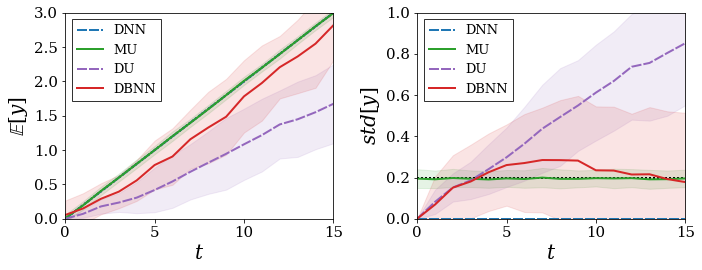

In [10]:
t = list(range(len(x_0ss[0])))

y_exp_means, y_exp_stds = [], []
for y_exps in [dnn_y_exps, mu_y_exps, du_y_exps, dbnn_y_exps]:
    y_exps = [[y[1][0].numpy() if y is not None else np.nan for y in y_exp] for y_exp in y_exps]
    y_exp_means.append(np.nanmean(y_exps, axis=0))
    y_exp_stds.append(np.nanstd(y_exps, axis=0))

y_std_means, y_std_stds = [], []
for y_vars in [dnn_y_vars, mu_y_vars, du_y_vars, dbnn_y_vars]:
    y_vars = [[y[1][0].numpy() if y is not None else np.nan for y in y_var] for y_var in y_vars]
    y_stds = np.sqrt(y_vars)
    y_std_means.append(np.nanmean(y_stds, axis=0))
    y_std_stds.append(np.nanstd(y_stds, axis=0))
    
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# expected value
ax1.set_xlim(t[0], t[-1])
ax1.set_ylim(x_0_meanss[0][0], x_0_meanss[0][-1])
ax1.set_xlabel("$t$")
ax1.set_ylabel("$\mathbb{E}[y]$")

ax1.plot(t, x_0_meanss[0], linestyle=guide_linestyle, color='black')
for y_exp_mean, y_exp_std, linestyle, label, color in zip(y_exp_means, y_exp_stds, linestyles, labels, colors):
    ax1.fill_between(t, y_exp_mean + 1.65 * y_exp_std, y_exp_mean - 1.65 * y_exp_std, color=color, alpha=alpha)
    ax1.plot(t, y_exp_mean, linestyle=linestyle, label=label, color=color)
ax1.legend(edgecolor='black', fancybox=False)


# std
ax2.set_xlim(t[0], t[-1])
ax2.set_ylim(0, )
ax2.set_xlabel("$t$")
ax2.set_ylabel("$std[y]$")

ax2.plot(t, x_0_meanss[0] * x_1_vars[0] + x_1_vars[1], linestyle=guide_linestyle, color='black')
for y_std_mean, y_std_std, linestyle, label, color in zip(y_std_means, y_std_stds, linestyles, labels, colors):
    ax2.fill_between(t, y_std_mean + 1.65 * y_std_std, y_std_mean - 1.65 * y_std_std, color=color, alpha=alpha)
    ax2.plot(t, y_std_mean, linestyle=linestyle, label=label, color=color)
ax2.legend(edgecolor='black', fancybox=False)

plt.tight_layout()